Cria o arquivo "data.pkl", que contém os dados necessários para o modelo.

In [19]:
!pip install pandas numpy requests

  Running setup.py install for wget ... done


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, os, io

In [18]:
# Faz o download dos dados
url = "https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv"
covid_file = requests.get(url)

df = pd.read_csv(io.BytesIO(covid_file.content))
df.head()

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,...,numdeaths_last14,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,35,Ontario,Ontario,2020-01-31,3,0,0.0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,British Columbia,Colombie-Britannique,2020-01-31,1,0,0.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Canada,Canada,2020-01-31,4,0,0.0,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35,Ontario,Ontario,2020-02-08,3,0,0.0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,British Columbia,Colombie-Britannique,2020-02-08,4,0,0.0,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Salva os dados de casos e mortes em canada_data.pkl
df.query('prname in ["Ontario","Quebec"]', inplace=True)

df["date"] = pd.to_datetime(df["date"])
df.sort_values(by=['date'], inplace=True)

date    = df['date'].unique()

# Soma o número de casos e calcula a quantidade de casos novos
tcases  = [df.loc[df['date'] == day, 'numconf'].sum() for day in date]
ncases  = np.append([0], np.diff(tcases))

tdeaths = [df.loc[df['date'] == day, 'numdeaths'].sum() for day in date]
ndeaths = np.append([0], np.diff(tdeaths))

df = pd.DataFrame({'date':date, 'tcases':tcases, 'ncases':ncases, 'tdeaths':tdeaths, 'ndeaths':ndeaths})
df.set_index('date', drop=True, inplace=True)

df.to_pickle('canada_data.pkl')
df.head()

,tcases,ncases,tdeaths,ndeaths
date,,,,
2020-01-31,3,0,0.0,0.0
2020-02-08,3,0,0.0,0.0
2020-02-16,3,0,0.0,0.0
2020-02-21,3,0,0.0,0.0
2020-02-24,4,1,0.0,0.0


In [20]:
# Vetor de datas para ser usado no dataset
Datas = np.arange('2020-03-01', '2020-11-20', dtype='datetime64[D]')
Datas[0:10]

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10'], dtype='datetime64[D]')

In [21]:
# Calcula a média móvel de start até end
def med_movel(df, start, end, column):
    start = pd.Timedelta(days = int(start))
    end   = pd.Timedelta(days = int(end))
    idx = df.index.values
    return np.array([df.loc[np.logical_and(day - idx < end, day - idx >= start), column].mean() for day in Datas])

,tcases,ncases,tdeaths,ndeaths
date,,,,
2020-01-31,3,0,0.0,0.0
2020-02-08,3,0,0.0,0.0
2020-02-16,3,0,0.0,0.0
2020-02-21,3,0,0.0,0.0
2020-02-24,4,1,0.0,0.0
...,...,...,...,...
2020-12-02,264984,3237,10823.0,76.0
2020-12-03,268278,3294,10867.0,44.0
2020-12-04,271403,3125,10920.0,53.0


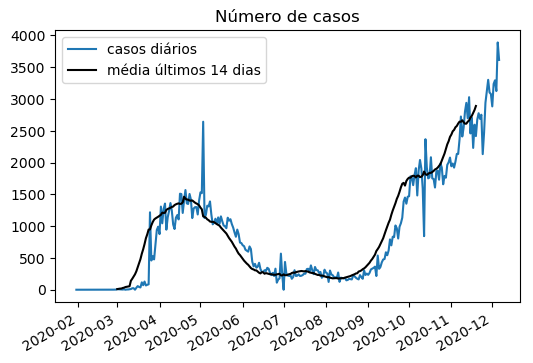

In [41]:
# Lê os dataframes e calcula a média móvel dos últimos 14 dias
df = pd.read_pickle("canada_data.pkl")

med_cases = med_movel(df, -14, 0, "ncases")
med_deaths = med_movel(df, -14, 0, "ndeaths")

plt.subplots(dpi=100)

plt.plot(df["ncases"], label="casos diários")
plt.plot(Datas, med_cases, "k", label="média últimos 14 dias")

plt.title("Número de casos")
plt.gcf().autofmt_xdate()
plt.legend(loc='best')
df

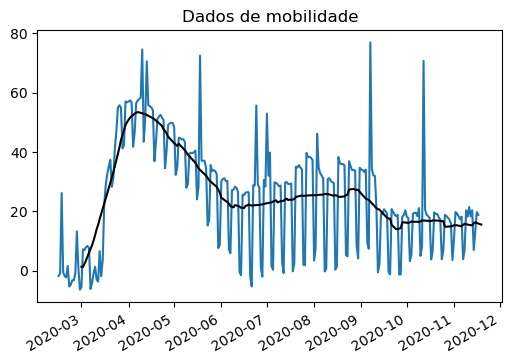

In [23]:
# Abre os arquivos de movimentação do Canadá
mobility_file = "data/2020_CA_Region_Mobility_Report.csv"
df2 = pd.read_csv(mobility_file)

df2.query('sub_region_1 in ["Ontario","Quebec"]', inplace=True)
df2["date"] = pd.to_datetime(df2["date"])
df2.sort_values(by=['date'],inplace=True)

date = df2["date"].unique()

# Calcula a média no Canadá em cada dia
mov = [df2.loc[day == df2["date"], "workplaces_percent_change_from_baseline"].mean()*-1 for day in date]

df2=pd.DataFrame({'date':date,'mov':mov})
df2.set_index('date', drop=True, inplace=True)

# Faz a média móvel dos 14 dias anteriores até os 14 dias seguintes e plota
med_mov = med_movel(df2, -14, 14, "mov")

plt.subplots(dpi=100)
plt.title("Dados de mobilidade")
plt.plot(df2["mov"])
plt.plot(Datas, med_mov, "k")
plt.gcf().autofmt_xdate()

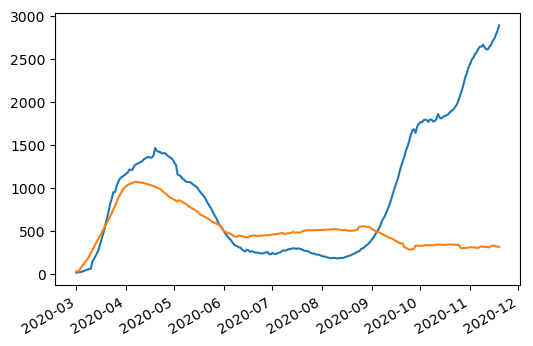

In [24]:
# Compara a movimantação com a quantidade de casos novos
plt.subplots(dpi=100)
plt.plot(Datas, med_cases)
plt.plot(Datas, med_mov * 20)
plt.gcf().autofmt_xdate()

In [25]:
# Salva tudo em data.pkl e data.csv
df = pd.DataFrame({'date':Datas, 'cases':med_cases, 'deaths':med_deaths, 'mov':med_mov})
df.set_index('date', drop=True, inplace=True)

df.to_pickle("data.pkl")
df.to_csv("data.csv")
df.head()

,cases,deaths,mov
date,,,
2020-03-01,10.090909,0.090909,1.367307
2020-03-02,14.000000,0.083333,1.227888
2020-03-03,17.166667,0.083333,2.279492
2020-03-04,18.615385,0.153846,3.508053
2020-03-05,27.307692,0.230769,4.840908
